## ESI Focus

Finds best focus for different kinds of images.

In [1]:
%matplotlib inline
import sys
import math
import matplotlib.pyplot as plt
from  matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import glob
import pandas as pd

import MosaicFitsReader as mfr
import FindSources as fs

import astropy.io.fits as pf
sys.path.append("../../libs/")
import HEq
import traceback

In [2]:
def findBestFocusHelper(pairs, weight=0, nloop=3):
    """
    Fits a hyperbola: x=focus, y=fwhm

    Hyperbola equation: y^2 = Ax^2 + Bx + C
    """
        
    if weight > 0:
        """
        Use two helper points to pull the curve up.
        These two points have lower weights (0.1).
        """
        xs = np.append(pairs[0], (-20, 30))
        ys = np.append(pairs[1], (4, 3.5))
    
        w = [1] * len(xs)
        w[-2] = w[-1] = weight
        w = np.divide (w, sum(w))
        nloop = 1
    else:
        xs = pairs[0]
        ys = pairs[1]
        w = [1] * len(xs)
    
    ysSqr = np.multiply(ys, ys) 
    """
    for i in range(nloop):
        coef = np.polyfit(xs, ysSqr, deg=2, w = w)
        func = np.poly1d(coef)
        w = np.abs(ysSqr - func(xs))
        w = np.divide(w, np.sum(w))
    """#
    coef = np.polyfit(xs, ysSqr, deg=2, w = w)
    return coef

def findBestFocus (pairs):
    for w in list((0, 0.1, 1)):
        coef = findBestFocusHelper(pairs, w)
        A, B, C = coef
        if A > 0:
            break
        else:
            print ("Use helper points because A is %.2e" % A)
        
    func = np.poly1d(coef)
    def func1 (x):
        return math.sqrt(max(0, func(x)))

    funcV = np.vectorize(func1)
    minX = -B/2/A
    return minX, funcV
    

In [3]:
def getFileGroups (fileList):
    with open(fileList) as fh:
        fileList = []
        for line in fh:
            if not 'OBJECT' in line:
                continue
            parts = line.strip().split()
            name, tpe = parts[0], ' '.join(parts[3:]).strip(" '")
            fileList.append((name, tpe))
    df = pd.DataFrame(fileList, columns=('name', 'imgType'))

    groups = df.groupby (by=df.imgType)
    return groups

groups = getFileGroups("data/2017nov16/files.list")
for k in groups.groups.keys():
    print (k)

LAMPAR1 lamp 1 sec
LAMPCU1 lamp 10 sec
LAMPNE1 lamp 1 sec
LAMPQTZ1 lamp 1 sec
bias
focusloop direct B
focusloop direct Clear_
focusloop direct EllisR
focusloop direct I
focusloop direct R
focusloop direct V
focusloop echellette
focusloop lowD


In [4]:
def getBestCens (cens, nr):
    """
    Sorts the given centroids by fwhm and filters out the duplicates.
    Returns the (nr) first cenroids.
    """
    if len(cens) < 1:
        return cens
    s = sorted (cens, key= lambda x : x[2], reverse=True)
    x0 = s[0]
    out = []
    for x in s[1:]:
        dx = x[0] - x0[0]
        if abs(dx) > 1E-2:
            out.append(x0)
        x0 = x
    return out[1:nr+1]

In [5]:
def findCentroids (data, roi, cellSize, nr):
    """
    Finds the best centroids in a given region of interest.
    data: full size image
    roi: region of interest (x0,x1),(y0,y1)
    cellSize: size of the search cell
    nr: number of centroids to return
    """
    (x0, x1), (y0, y1) = roi
    fc = fs.FindSources(data[y0:y1,x0:x1])
    cens = fc.findAll(cellSize, sfactor=2)
    half = cellSize//2
    fc = fs.FindSources(data[y0+half:y1,x0+half:x1])
    cens1 = fc.findAll(cellSize, sfactor=2)
    for cn in cens1:
        cnn = list (cn)
        cnn[0] += half
        cnn[1] += half
        cens.append(cnn)

    cens = getBestCens(cens, nr) 
    return cens

In [6]:
def findCentroids1D (data, roi, fwidth=30):
    (x0,x1),(y0,y1) = roi
    cut1d = data[y0,x0:x1]

    out = []
    for x in range(0, len(cut1d)-fwidth, fwidth):
        res, xc, std, cnt = fs.centroid1DLoop(cut1d, x, x+fwidth)
        fwhm = std * 2.35
        if res != 0 or fwhm > fwidth//5:
            continue
        out.append((xc, fwhm))
    return out

def findCentroids1DFiles (prefix, flist, roi, fwidth=30):
    out = []
    for n in flist:
        ff = pf.open(prefix + n)[0]
        collfocr = ff.header['COLLFOCR'] * 1E-4
        cens = findCentroids1D (ff.data, roi, fwidth)
        out.extend( ( (collfocr,x[1]) for x in cens) )
    return out

In [7]:
# Region of interest for focus loop images
RegionOfInterest = (415, 640), (1010, 1080)
EchelletteROI = (1250,1750),(1550,1750)
LowDROI = (200,1600), (2000, 2001)

In [8]:
def findCentroidsFiles(prefix, flist, roi):
    """
    Finds centroids in a list of files and associates them with the focus value (COLLFOR).
    Returns the fwhm/focus pairs.
    """
    useAll = True
    out = []
    currName = ""
    for n in flist:   
        ff = pf.open(prefix + n)[0]
        collfocr = ff.header['COLLFOCR'] * 1E-4
        cens = findCentroids(ff.data, roi, 17, 9)
        if len(cens) <= 0:
            continue
        if useAll:
            out.extend( ( (collfocr,x[2]) for x in cens) )
        else:
            avg = np.mean([ x[2] for x in cens ])
            out.append ((collfocr, avg))
    return out

In [9]:
def processOneFocusSet (prefix, flist, roi):
    out = findCentroidsFiles (prefix, flist, roi)
    outT = np.array(out).T
    minF, func = findBestFocus(outT)
    return outT, minF, func

def processOneFocusSet1D (prefix, flist, roi):
    out = findCentroids1DFiles (prefix, flist, roi)
    outT = np.array(out).T
    minF, func = findBestFocus(outT)
    return outT, minF, func

def plotOneFocusSet (pdf, title, focVals, fwhms, func):
    fig = plt.figure(figsize=(10, 3))
    plt.title (title)
    xs = focVals * 1E4
    plt.plot(xs, fwhms, '.')
    
    xs1 = np.linspace(min(xs), max(xs), 25)
    fv1 = np.linspace(min(focVals), max(focVals), 25)
    plt.plot(xs1, func(fv1), '-', label='fitted')
    plt.grid()
    plt.legend()
    plt.ylabel('FWHM ["]')
    plt.xlabel ("Focus (COLLFOCR)")
    plt.tight_layout()
    if pdf:
        pdf.savefig(fig)
        plt.close(fig)

In [10]:
def processFocusImages (pdf, prefix, groups):
    def processOne(gname, roi, pfunc):
        print ("Processing", gname)
        files = groups.get_group(gname).name
        pairs, minF, func = pfunc(prefix, files, roi) 
        title = gname + " - Best Focus=%.0f" % (minF * 1E4)
        plotOneFocusSet (pdf, title, pairs[0], pairs[1], func)

    for k in groups.groups.keys():
        if not 'focusloop direct' in k:
            continue
        processOne (k, RegionOfInterest, processOneFocusSet)
    
    processOne ('focusloop echellette', EchelletteROI, processOneFocusSet) 
    processOne ('focusloop lowD', LowDROI, processOneFocusSet1D)    

In [11]:
with PdfPages('2017nov16.pdf') as pdf:
    processFocusImages(pdf, "data/2017nov16/", groups)

Processing focusloop direct B
Processing focusloop direct Clear_
Processing focusloop direct EllisR
Processing focusloop direct I
Processing focusloop direct R
Processing focusloop direct V
Processing focusloop echellette
Processing focusloop lowD


In [17]:
pairs, minF, func = processOneFocusSet("data/2017nov16/", 
    groups.get_group('focusloop direct V').name, RegionOfInterest)

In [13]:
echelleROI = (1250,1750),(1550,1750)
pairs, minF, func = processOneFocusSet("data/2017nov16/", 
        groups.get_group('focusloop echellette').name, echelleROI)

In [14]:
pairs, minF, func = processOneFocusSet1D("data/2017nov16/", 
        groups.get_group('focusloop lowD').name, LowDROI)

8.3949037288


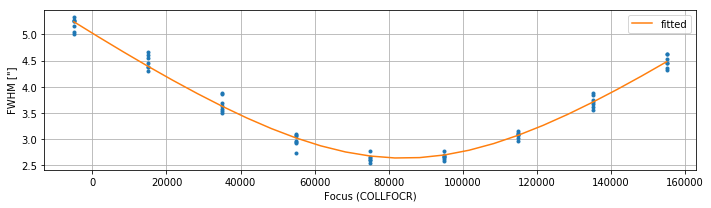

In [18]:
plotOneFocusSet(None, "", pairs[0], pairs[1], func)
print (minF)

In [16]:
# Special cases echellette and lowD